# Calculation of excited state energies

- Many algorithms are proposed and used for classical methods
 - Monte-Carlo (Variational, Diffusion)
 - Symmetry/orthogonality constraints on variational loss[Prof. Izmaylov's lecture]
 - etc...

- Several algorithms are proposed for VQE
 - Enforce orthogonality in input (SSVQE [2](https://arxiv.org/pdf/1810.09434.pdf), [3](https://dojo.qulacs.org/ja/latest/notebooks/6.3_subspace_search_VQE.html))
 - Enforce orthogonality in output
 - etc...

## SSVQE Algorithm
1. Select target exited state. Let it be $k$-th state for now.
2. Minimize $\mathcal{L}_{1}(\boldsymbol{\theta})=\sum_{j=0}^{k}\left\langle\varphi_{j}\left|U^{\dagger}(\boldsymbol{\theta}) H U(\boldsymbol{\theta})\right| \varphi_{j}\right\rangle$, where $\left\{\left|\varphi_{j}\right\rangle\right\}_{j=0}^{k}$ are k different computational basis are k different computational basis
3. Maximize $\mathcal{L}_{2}(\phi)=\left\langle\varphi_{k}\left|V^{\dagger}(\phi) U^{\dagger}\left(\boldsymbol{\theta}^{*}\right) H U\left(\boldsymbol{\theta}^{*}\right) V(\boldsymbol{\phi})\right| \varphi_{k}\right\rangle$

This works because
1. If we minimize $\mathcal{L}_{1}(\boldsymbol{\theta})$, it should be $\sum_{j=0}^{k} E_k$, therefore the space after applying unitary $U(\boldsymbol{\theta})$ only includes $\left\{\left|E_{j}\right\rangle\right\}_{j=0}^{k}$
2. If we maximize $\mathcal{L}_{2}(\phi)$, then we are searching maximum in the space where the largest enegy is $E_k$, eventually outputs $E_k$

## SSVQE algorithm variant with single loss is

1. Minimize $ \mathcal{L}_{w}(\boldsymbol{\theta})=w\left\langle\varphi_{k}\left|U^{\dagger}(\boldsymbol{\theta}) H U(\boldsymbol{\theta})\right| \varphi_{k}\right\rangle+ \sum_{j=0}^{k-1}\left\langle\varphi_{j}\left|U^{\dagger}(\boldsymbol{\theta}) H U(\boldsymbol{\theta})\right| \varphi_{j}\right\rangle $ where  $w \in (0, 1)$
2. Calculate expectation value w.r.t. $\left|\varphi_{k}\right\rangle$

This works because

1. $k$ th state has looser regularization compared to others because of $w$, therefore it optimizes $j\ne k $ first to map $\left|\varphi_{j}\right\rangle $ to $\left\{\left|E_{j}\right\rangle\right\}_{j=0}^{j=k-1}$, while maping $\left|\varphi_{k}\right\rangle$ to $\left\{\left|E_{k}\right\rangle\right\}$


### Here we show SSVQE result for H2
- There seems to be a stagnation point around -0.58 [eV] for 1st excited state. It is also shown in the graph in [author's tutorial](https://dojo.qulacs.org/ja/latest/notebooks/6.3_subspace_search_VQE.html).
- We could not exceed this point if we use UCCSD, instead we use the hardware efficient ansatz as used in [this paper](https://arxiv.org/abs/1704.05018).

In [1]:
import numpy as np
import tequila as tq
from tequila import QCircuit
from tequila.circuit.gates import X, Ry, Rz, CZ
from utility import *
threshold = 1e-6 #Cutoff for UCC MP2 amplitudes and QCC ranking gradients
h2, _ = get_qubit_hamiltonian(mol='h2', geometry=0.977, basis='sto3g', qubit_transf='jw')
mat = QubitHamiltonian.from_openfermion(h2).to_matrix()
eigval, eigvec = np.linalg.eigh(mat)

print('ground state energy', eigval[0])
print('1st excited state energy', eigval[1])

ground state energy -1.105933352304692
1st excited state energy -0.7329846745974556


In [2]:
trotter_steps = 1
xyz_data = get_molecular_data('h2', geometry=0.977, xyz_format=True)
h2 = tq.quantumchemistry.Molecule(geometry=xyz_data, basis_set='sto-3g')
H = h2.make_hamiltonian()


def he_ansatz_circuit(n_qubit, depth, theta_list):
    """he_ansatz_circuit
    Returns hardware efficient ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubit used (equivalent to the number of fermionic modes)
        depth (:class:`int`):
            depth of the circuit.
        theta_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :class:`qulacs.QuantumCircuit`
    """
    circuit = QCircuit()
    circuit+=Ry(target=0, angle=tq.Variable('a'))
    circuit+=Ry(target=0, angle=tq.Variable('b'))
    for d in range(depth):
        for i in range(n_qubit):
            circuit += Ry(target=i, angle=tq.Variable(f'{d}-{i}-y'))
            circuit += Rz(target=i, angle=tq.Variable(f'{d}-{i}-z'))
        for i in range(n_qubit//2):
            circuit += CZ(2*i, 2*i+1)
        for i in range(n_qubit//2-1):
            circuit += CZ(2*i+1, 2*i+2)
    for i in range(n_qubit):
        circuit += Ry(target=i, angle=tq.Variable(f'{i}-y-2'))
        circuit += Rz(target=i, angle=tq.Variable(f'{i}-z-2'))

    return circuit

In [3]:
n_qubit = 2* h2.n_orbitals
U_UCCSD = h2.make_uccsd_ansatz(initial_amplitudes='mp2',threshold=threshold, trotter_steps=trotter_steps)
U_UCCSD2 = h2.make_uccsd_ansatz(initial_amplitudes='mp2',threshold=threshold, trotter_steps=trotter_steps).insert_gates([0], [X(0)])
depth =n_qubit
init_theta_list = np.random.random(2*n_qubit*(depth+1)+2)*1e-1
U = he_ansatz_circuit(n_qubit, n_qubit, init_theta_list)
U2 = he_ansatz_circuit(n_qubit, n_qubit, init_theta_list).insert_gates([0], [X(0)])

In [10]:
E0 = tq.ExpectationValue(H=H, U=U)
E1 = tq.ExpectationValue(H=H, U=U2)
E = E0 + 0.4 * E1

print('\nStarting optimization:\n')

result = tq.minimize(objective=E, method="BFGS", initial_values={k: np.random.random(1) * 1e-1 for k in E.extract_variables()}, tol=1e-6, maxiter=500, disp=True)



Starting optimization:

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 2 expectationvalues
gradient        : 252 expectationvalues

active variables : 42

E=+0.26946843  angles= {a: 0.005686745822072881, b: 0.02094191972363012, 0-0-y: 0.0005541331920693393, 0-0-z: 0.05983976493766968, 0-1-y: 0.05185818749455428, 0-1-z: 0.073459066853485, 0-2-y: 0.07426647821353256, 0-2-z: 0.0889887196999806, 0-3-y: 0.04297736206563607, 0-3-z: 0.08000088069002553, 1-0-y: 0.0405479938676766, 1-0-z: 0.005628608838270888, 1-1-y: 0.02873796339372612, 1-1-z: 0.09440078826594553, 1-2-y: 0.09602641150450489, 1-2-z: 0.020278551071168584, 1-3-y: 0.012907602452311963, 1-3-z: 0.06252942938605076, 2-0-y: 0.007602715491812773, 2-0-z: 0.04165135435836077, 2-1-y: 0.008651632661192355, 2-1-z: 0.013767083100253642, 2-2-y: 0.023785322478920436, 2-2-z: 0.01861716

KeyboardInterrupt: 

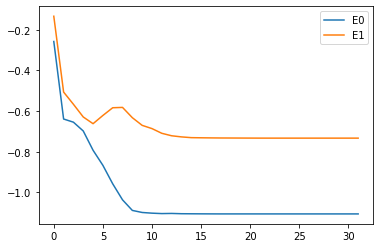

In [15]:
import pandas as pd
df = pd.DataFrame()
for i, angle in enumerate(result.history.angles):
    df[i] = pd.Series({"E0": tq.simulate(E0, angle),
             "E1": tq.simulate(E1, angle)})

df.T.plot()

Convergence to -1.39912450 gives $E_1$ as -1.39912450 - (- 1.1056) / 0.4 $\sim$ -0.733, which is fairly good.